In [ ]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [ ]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

In [ ]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)



In [ ]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [ ]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [ ]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)


In [ ]:
train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [ ]:
# =========================
# MSCViT CONFIG
# =========================
MSCViT_CONFIGS = {
    "MSCViT-T": {
        "stem_channels": 16,
        "stages": [
            {"C": 32,  "P": 3, "R": 4},
            {"C": 64,  "P": 3, "R": 3},
            {"C": 128, "P": 5, "R": 2},
            {"C": 256, "P": 5, "R": 1},
        ],
    },
    "MSCViT-XS": {
        "stem_channels": 24,
        "stages": [
            {"C": 48,  "P": 3, "R": 4},
            {"C": 96,  "P": 3, "R": 3},
            {"C": 192, "P": 5, "R": 2},
            {"C": 384, "P": 5, "R": 1},
        ],
    },
    "MSCViT-S": {
        "stem_channels": 32,
        "stages": [
            {"C": 64,  "P": 3, "R": 4},
            {"C": 128, "P": 3, "R": 3},
            {"C": 256, "P": 5, "R": 2},
            {"C": 512, "P": 5, "R": 1},
        ],
    },
}

import torch
import torch.nn as nn

# =========================
# STEM
# =========================
class ConvStem(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

# =========================
# DEPTHWISE CONV
# =========================
class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, 3, padding=1, groups=dim, bias=False)
        self.pw = nn.Conv2d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

# =========================
# LOCAL FEATURE EXTRACTOR
# =========================
class LFE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = DWConv(dim)

    def forward(self, x):
        return self.conv(x)

# =========================
# CHANNEL MIXER
# =========================
class ChannelMixer(nn.Module):
    def __init__(self, dim, expansion=2):
        super().__init__()
        hidden = dim * expansion
        self.fc1 = nn.Conv2d(dim, hidden, 1, bias=False)
        self.act = nn.GELU()
        self.fc2 = nn.Conv2d(hidden, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)

    def forward(self, x):
        return self.bn(self.fc2(self.act(self.fc1(x))))

# =========================
# MSC BLOCK
# =========================
class MSCBlock(nn.Module):
    def __init__(self, dim, attn_depth):
        super().__init__()
        self.lfe = LFE(dim)
        self.mixers = nn.ModuleList(
            [ChannelMixer(dim) for _ in range(attn_depth)]
        )

    def forward(self, x):
        x = x + self.lfe(x)
        for m in self.mixers:
            x = x + m(x)
        return x

# =========================
# STAGE
# =========================
class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, attn_depth):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.blocks = nn.ModuleList(
            [MSCBlock(out_channels, attn_depth) for _ in range(num_blocks)]
        )

    def forward(self, x):
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x)
        return x

# =========================
# MSCViT (BINARY CLASSIFIER)
# =========================
class MSCViT(nn.Module):
    def __init__(self, variant="MSCViT-T", num_classes=1, global_pool="avg"):
        super().__init__()

        cfg = MSCViT_CONFIGS[variant]
        self.__class__.__name__ = variant

        self.stem = ConvStem(cfg["stem_channels"])

        in_ch = cfg["stem_channels"]
        self.stages = nn.ModuleList()

        for s in cfg["stages"]:
            self.stages.append(Stage(in_ch, s["C"], s["P"], s["R"]))
            in_ch = s["C"]

        # 🔥 BINARY HEAD (1 LOGIT)
        self.head = nn.Linear(in_ch, num_classes)
        self.global_pool = global_pool

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)

        x = x.mean((2, 3)) if self.global_pool == "avg" else x.amax((2, 3))
        return self.head(x)  # logits (NO SIGMOID)


In [ ]:
from torchinfo import summary

model = MSCViT(
    variant="MSCViT-T",
    num_classes=1   # 🔥 REQUIRED FOR BINARY
).to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params"),
)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
MSCViT-T                                                [1, 3, 224, 224]          [1, 1]                    --
├─ConvStem: 1-1                                         [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    └─Sequential: 2-1                                  [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                            [1, 16, 112, 112]         [1, 16, 112, 112]         32
│    │    └─ReLU: 3-3                                   [1, 16, 112, 112]         [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-4                                 [1, 16, 112, 112]         [1, 16, 112, 112]         2,304
│    │    └─BatchNorm2d: 3-5                            [1, 16, 112, 112]         [1, 16, 112, 112]    

In [ ]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score
)

def custom_metrics(y_logits, y_true, loss):
    """
    Custom evaluation metrics for BINARY classification.

    Args:
        y_logits (Tensor): Raw model outputs (logits), shape (B,) or (B, 1)
        y_true   (Tensor): Ground truth labels, shape (B,) or (B, 1)
        loss     (float): Loss value

    Returns:
        dict: Dictionary of computed metrics
    """

    # ---------- SHAPE FIX ----------
    y_logits = y_logits.squeeze()
    y_true = y_true.squeeze()

    # ---------- PROBABILITIES & PREDICTIONS ----------
    y_probs = torch.sigmoid(y_logits)
    y_pred = (y_probs > 0.5).int()

    # ---------- NUMPY ----------
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    y_probs_np = y_probs.detach().cpu().numpy()

    # ---------- BASIC METRICS ----------
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, zero_division=0)

    # ---------- CONFUSION MATRIX ----------
    cm = confusion_matrix(y_true_np, y_pred_np)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)

    # ---------- MCC ----------
    mcc = matthews_corrcoef(y_true_np, y_pred_np)

    # ---------- AUC ----------
    try:
        auc = roc_auc_score(y_true_np, y_probs_np)
    except ValueError:
        auc = np.nan

    # ---------- METRICS DICT ----------
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc,
    }

    return metrics


In [ ]:
# =========================
# Hyperparameters
# =========================
num_epochs        = 25
initial_lr        = 1e-4
decay_start_epoch = 10
decay_factor      = 0.97

# =========================
# Criterion & Optimizer (BINARY)
# =========================
criterion = nn.BCEWithLogitsLoss()   # 🔥 FIXED (was CrossEntropyLoss)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# =========================
# Scheduler
# =========================
# LR = 1.0 until epoch 10, then decay_factor^(epoch - decay_start_epoch)
lr_lambda = lambda epoch: (
    1.0 if epoch < decay_start_epoch
    else decay_factor ** (epoch - decay_start_epoch)
)

scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lr_lambda
)


In [ ]:
# =========================
# Metrics initialization
# =========================
metric_names = [
    "loss", "accuracy", "precision", "recall", "f1_score",
    "specificity", "sensitivity", "mcc", "auc"
]

train_metrics_history = {m: [] for m in metric_names}
val_metrics_history   = {m: [] for m in metric_names}

total_training_time   = 0.0
total_validation_time = 0.0

# =========================
# Training Loop
# =========================
for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    total_loss = 0.0

    all_logits = []
    all_targets = []

    for data, targets in tqdm(
        train_loader,
        desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]"
    ):
        data = data.to(device)
        targets = targets.to(device).float()   # 🔥 MUST BE FLOAT

        optimizer.zero_grad()

        logits = model(data).squeeze(1)        # 🔥 (B,)
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    # ---------- METRICS ----------
    avg_train_loss = total_loss / len(train_loader)

    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)

    train_metrics = custom_metrics(
        all_logits,
        all_targets,
        avg_train_loss
    )

    print(
        "Train Metrics - " +
        ", ".join(
            f"{k}: {v:.4f}" if k != "auc" else f"{k}: {v:.4f}"
            for k, v in train_metrics.items()
        )
    )

    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])

    # =========================
    # Validation Loop
    # =========================
    model.eval()
    total_loss = 0.0

    all_logits = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for data, targets in tqdm(
            val_loader,
            desc=f"Validating Model - Epoch [{epoch + 1}/{num_epochs}]"
        ):
            data = data.to(device)
            targets = targets.to(device).float()   # 🔥 MUST BE FLOAT

            logits = model(data).squeeze(1)
            loss = criterion(logits, targets)

            total_loss += loss.item()

            all_logits.append(logits.detach().cpu())
            all_targets.append(targets.detach().cpu())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time

    # ---------- METRICS ----------
    avg_val_loss = total_loss / len(val_loader)

    all_logits = torch.cat(all_logits)
    all_targets = torch.cat(all_targets)

    val_metrics = custom_metrics(
        all_logits,
        all_targets,
        avg_val_loss
    )

    print(
        "Val Metrics   - " +
        ", ".join(
            f"{k}: {v:.4f}" if k != "auc" else f"{k}: {v:.4f}"
            for k, v in val_metrics.items()
        )
    )

    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])

    # ---------- LR Scheduler ----------
    scheduler.step()

# =========================
# Timing Summary
# =========================
print(f"Total Training Time: {timedelta(seconds=total_training_time)}")
print(f"Total Validation Time: {timedelta(seconds=total_validation_time)}")

print(
    f"Average Training Time per Epoch: "
    f"{timedelta(seconds=total_training_time / num_epochs)}"
)

print(
    f"Average Validation Time per Epoch: "
    f"{timedelta(seconds=total_validation_time / num_epochs)}"
)


Training Model - Epoch [1/25]: 100%|██████████| 1168/1168 [04:28<00:00,  4.35it/s]


Train Metrics - loss: 0.4451, accuracy: 0.7959, precision: 0.5910, recall: 0.3049, f1_score: 0.4023, specificity: 0.9386, sensitivity: 0.3049, mcc: 0.3174, auc: 0.7796


Validating Model - Epoch [1/25]: 100%|██████████| 251/251 [00:56<00:00,  4.41it/s]


Val Metrics   - loss: 0.4424, accuracy: 0.8026, precision: 0.5809, recall: 0.4457, f1_score: 0.5044, specificity: 0.9065, sensitivity: 0.4457, mcc: 0.3891, auc: 0.7898


Training Model - Epoch [2/25]: 100%|██████████| 1168/1168 [02:53<00:00,  6.74it/s]


Train Metrics - loss: 0.4239, accuracy: 0.8072, precision: 0.6231, recall: 0.3650, f1_score: 0.4604, specificity: 0.9358, sensitivity: 0.3650, mcc: 0.3713, auc: 0.8052


Validating Model - Epoch [2/25]: 100%|██████████| 251/251 [00:37<00:00,  6.72it/s]


Val Metrics   - loss: 0.4192, accuracy: 0.8109, precision: 0.7164, recall: 0.2661, f1_score: 0.3880, specificity: 0.9694, sensitivity: 0.2661, mcc: 0.3552, auc: 0.8147


Training Model - Epoch [3/25]: 100%|██████████| 1168/1168 [02:57<00:00,  6.58it/s]


Train Metrics - loss: 0.4133, accuracy: 0.8125, precision: 0.6367, recall: 0.3907, f1_score: 0.4842, specificity: 0.9352, sensitivity: 0.3907, mcc: 0.3944, auc: 0.8177


Validating Model - Epoch [3/25]: 100%|██████████| 251/251 [00:35<00:00,  7.08it/s]


Val Metrics   - loss: 0.4261, accuracy: 0.8159, precision: 0.6571, recall: 0.3825, f1_score: 0.4835, specificity: 0.9420, sensitivity: 0.3825, mcc: 0.4016, auc: 0.8201


Training Model - Epoch [4/25]: 100%|██████████| 1168/1168 [02:55<00:00,  6.67it/s]


Train Metrics - loss: 0.4022, accuracy: 0.8166, precision: 0.6420, recall: 0.4206, f1_score: 0.5083, specificity: 0.9318, sensitivity: 0.4206, mcc: 0.4151, auc: 0.8298


Validating Model - Epoch [4/25]: 100%|██████████| 251/251 [00:37<00:00,  6.61it/s]


Val Metrics   - loss: 0.4007, accuracy: 0.8221, precision: 0.6243, recall: 0.5288, f1_score: 0.5726, specificity: 0.9074, sensitivity: 0.5288, mcc: 0.4638, auc: 0.8331


Training Model - Epoch [5/25]: 100%|██████████| 1168/1168 [02:54<00:00,  6.70it/s]


Train Metrics - loss: 0.3922, accuracy: 0.8208, precision: 0.6478, recall: 0.4480, f1_score: 0.5296, specificity: 0.9292, sensitivity: 0.4480, mcc: 0.4344, auc: 0.8411


Validating Model - Epoch [5/25]: 100%|██████████| 251/251 [00:38<00:00,  6.52it/s]


Val Metrics   - loss: 0.4080, accuracy: 0.8129, precision: 0.6114, recall: 0.4656, f1_score: 0.5286, specificity: 0.9139, sensitivity: 0.4656, mcc: 0.4205, auc: 0.8238


Training Model - Epoch [6/25]: 100%|██████████| 1168/1168 [02:56<00:00,  6.63it/s]


Train Metrics - loss: 0.3805, accuracy: 0.8271, precision: 0.6628, recall: 0.4731, f1_score: 0.5521, specificity: 0.9300, sensitivity: 0.4731, mcc: 0.4584, auc: 0.8517


Validating Model - Epoch [6/25]: 100%|██████████| 251/251 [00:40<00:00,  6.27it/s]


Val Metrics   - loss: 0.4023, accuracy: 0.8186, precision: 0.6415, recall: 0.4424, f1_score: 0.5236, specificity: 0.9281, sensitivity: 0.4424, mcc: 0.4272, auc: 0.8328


Training Model - Epoch [7/25]: 100%|██████████| 1168/1168 [02:56<00:00,  6.60it/s]


Train Metrics - loss: 0.3654, accuracy: 0.8362, precision: 0.6834, recall: 0.5083, f1_score: 0.5830, specificity: 0.9315, sensitivity: 0.5083, mcc: 0.4920, auc: 0.8653


Validating Model - Epoch [7/25]: 100%|██████████| 251/251 [00:35<00:00,  7.04it/s]


Val Metrics   - loss: 0.4111, accuracy: 0.8129, precision: 0.5855, recall: 0.5809, f1_score: 0.5832, specificity: 0.8804, sensitivity: 0.5809, mcc: 0.4626, auc: 0.8298


Training Model - Epoch [8/25]: 100%|██████████| 1168/1168 [02:51<00:00,  6.81it/s]


Train Metrics - loss: 0.3457, accuracy: 0.8429, precision: 0.6954, recall: 0.5383, f1_score: 0.6068, specificity: 0.9314, sensitivity: 0.5383, mcc: 0.5172, auc: 0.8821


Validating Model - Epoch [8/25]: 100%|██████████| 251/251 [00:36<00:00,  6.81it/s]


Val Metrics   - loss: 0.4137, accuracy: 0.8164, precision: 0.6452, recall: 0.4113, f1_score: 0.5024, specificity: 0.9342, sensitivity: 0.4113, mcc: 0.4116, auc: 0.8222


Training Model - Epoch [9/25]: 100%|██████████| 1168/1168 [03:01<00:00,  6.45it/s]


Train Metrics - loss: 0.3187, accuracy: 0.8606, precision: 0.7333, recall: 0.5991, f1_score: 0.6594, specificity: 0.9366, sensitivity: 0.5991, mcc: 0.5775, auc: 0.9011


Validating Model - Epoch [9/25]: 100%|██████████| 251/251 [00:35<00:00,  7.09it/s]


Val Metrics   - loss: 0.4399, accuracy: 0.8151, precision: 0.6220, recall: 0.4579, f1_score: 0.5275, specificity: 0.9191, sensitivity: 0.4579, mcc: 0.4234, auc: 0.8166


Training Model - Epoch [10/25]: 100%|██████████| 1168/1168 [02:55<00:00,  6.64it/s]


Train Metrics - loss: 0.2775, accuracy: 0.8808, precision: 0.7714, recall: 0.6690, f1_score: 0.7166, specificity: 0.9424, sensitivity: 0.6690, mcc: 0.6442, auc: 0.9272


Validating Model - Epoch [10/25]: 100%|██████████| 251/251 [00:38<00:00,  6.49it/s]


Val Metrics   - loss: 0.4695, accuracy: 0.8029, precision: 0.5901, recall: 0.4102, f1_score: 0.4840, specificity: 0.9171, sensitivity: 0.4102, mcc: 0.3763, auc: 0.7955


Training Model - Epoch [11/25]: 100%|██████████| 1168/1168 [02:58<00:00,  6.53it/s]


Train Metrics - loss: 0.2363, accuracy: 0.8995, precision: 0.8030, recall: 0.7341, f1_score: 0.7670, specificity: 0.9476, sensitivity: 0.7341, mcc: 0.7042, auc: 0.9479


Validating Model - Epoch [11/25]: 100%|██████████| 251/251 [00:37<00:00,  6.61it/s]


Val Metrics   - loss: 0.5512, accuracy: 0.7992, precision: 0.5857, recall: 0.3714, f1_score: 0.4545, specificity: 0.9236, sensitivity: 0.3714, mcc: 0.3521, auc: 0.8027


Training Model - Epoch [12/25]: 100%|██████████| 1168/1168 [02:52<00:00,  6.79it/s]


Train Metrics - loss: 0.1918, accuracy: 0.9221, precision: 0.8480, recall: 0.7971, f1_score: 0.8218, specificity: 0.9585, sensitivity: 0.7971, mcc: 0.7726, auc: 0.9660


Validating Model - Epoch [12/25]: 100%|██████████| 251/251 [00:35<00:00,  7.14it/s]


Val Metrics   - loss: 0.5899, accuracy: 0.7942, precision: 0.5549, recall: 0.4368, f1_score: 0.4888, specificity: 0.8981, sensitivity: 0.4368, mcc: 0.3663, auc: 0.7835


Training Model - Epoch [13/25]: 100%|██████████| 1168/1168 [02:50<00:00,  6.87it/s]


Train Metrics - loss: 0.1478, accuracy: 0.9401, precision: 0.8796, recall: 0.8505, f1_score: 0.8648, specificity: 0.9661, sensitivity: 0.8505, mcc: 0.8265, auc: 0.9802


Validating Model - Epoch [13/25]: 100%|██████████| 251/251 [00:33<00:00,  7.38it/s]


Val Metrics   - loss: 0.7142, accuracy: 0.7932, precision: 0.5422, recall: 0.5266, f1_score: 0.5343, specificity: 0.8707, sensitivity: 0.5266, mcc: 0.4015, auc: 0.7974


Training Model - Epoch [14/25]: 100%|██████████| 1168/1168 [02:52<00:00,  6.76it/s]


Train Metrics - loss: 0.1226, accuracy: 0.9509, precision: 0.9034, recall: 0.8755, f1_score: 0.8892, specificity: 0.9728, sensitivity: 0.8755, mcc: 0.8578, auc: 0.9864


Validating Model - Epoch [14/25]: 100%|██████████| 251/251 [00:37<00:00,  6.72it/s]


Val Metrics   - loss: 0.7762, accuracy: 0.7799, precision: 0.5129, recall: 0.4623, f1_score: 0.4863, specificity: 0.8723, sensitivity: 0.4623, mcc: 0.3475, auc: 0.7743


Training Model - Epoch [15/25]: 100%|██████████| 1168/1168 [03:02<00:00,  6.40it/s]


Train Metrics - loss: 0.1043, accuracy: 0.9593, precision: 0.9166, recall: 0.9011, f1_score: 0.9088, specificity: 0.9762, sensitivity: 0.9011, mcc: 0.8826, auc: 0.9898


Validating Model - Epoch [15/25]: 100%|██████████| 251/251 [00:36<00:00,  6.90it/s]


Val Metrics   - loss: 0.7618, accuracy: 0.7869, precision: 0.5301, recall: 0.4778, f1_score: 0.5026, specificity: 0.8768, sensitivity: 0.4778, mcc: 0.3683, auc: 0.7748


Training Model - Epoch [16/25]: 100%|██████████| 1168/1168 [02:53<00:00,  6.74it/s]


Train Metrics - loss: 0.0909, accuracy: 0.9657, precision: 0.9320, recall: 0.9147, f1_score: 0.9232, specificity: 0.9806, sensitivity: 0.9147, mcc: 0.9013, auc: 0.9924


Validating Model - Epoch [16/25]: 100%|██████████| 251/251 [00:37<00:00,  6.73it/s]


Val Metrics   - loss: 0.9028, accuracy: 0.8016, precision: 0.6023, recall: 0.3525, f1_score: 0.4448, specificity: 0.9323, sensitivity: 0.3525, mcc: 0.3517, auc: 0.7848


Training Model - Epoch [17/25]: 100%|██████████| 1168/1168 [03:08<00:00,  6.21it/s]


Train Metrics - loss: 0.0739, accuracy: 0.9724, precision: 0.9448, recall: 0.9318, f1_score: 0.9383, specificity: 0.9842, sensitivity: 0.9318, mcc: 0.9205, auc: 0.9949


Validating Model - Epoch [17/25]: 100%|██████████| 251/251 [00:36<00:00,  6.97it/s]


Val Metrics   - loss: 0.9207, accuracy: 0.7974, precision: 0.5693, recall: 0.4146, f1_score: 0.4798, specificity: 0.9087, sensitivity: 0.4146, mcc: 0.3648, auc: 0.7830


Training Model - Epoch [18/25]: 100%|██████████| 1168/1168 [02:55<00:00,  6.65it/s]


Train Metrics - loss: 0.0709, accuracy: 0.9751, precision: 0.9491, recall: 0.9396, f1_score: 0.9444, specificity: 0.9853, sensitivity: 0.9396, mcc: 0.9283, auc: 0.9949


Validating Model - Epoch [18/25]: 100%|██████████| 251/251 [00:36<00:00,  6.82it/s]


Val Metrics   - loss: 0.9144, accuracy: 0.8004, precision: 0.5868, recall: 0.3858, f1_score: 0.4656, specificity: 0.9210, sensitivity: 0.3858, mcc: 0.3608, auc: 0.7781


Training Model - Epoch [19/25]: 100%|██████████| 1168/1168 [02:58<00:00,  6.53it/s]


Train Metrics - loss: 0.0579, accuracy: 0.9790, precision: 0.9556, recall: 0.9510, f1_score: 0.9533, specificity: 0.9871, sensitivity: 0.9510, mcc: 0.9398, auc: 0.9969


Validating Model - Epoch [19/25]: 100%|██████████| 251/251 [00:35<00:00,  6.97it/s]


Val Metrics   - loss: 1.0392, accuracy: 0.7989, precision: 0.5696, recall: 0.4401, f1_score: 0.4966, specificity: 0.9033, sensitivity: 0.4401, mcc: 0.3783, auc: 0.7898


Training Model - Epoch [20/25]: 100%|██████████| 1168/1168 [02:51<00:00,  6.80it/s]


Train Metrics - loss: 0.0571, accuracy: 0.9795, precision: 0.9577, recall: 0.9513, f1_score: 0.9545, specificity: 0.9878, sensitivity: 0.9513, mcc: 0.9413, auc: 0.9971


Validating Model - Epoch [20/25]: 100%|██████████| 251/251 [00:38<00:00,  6.49it/s]


Val Metrics   - loss: 1.0033, accuracy: 0.7842, precision: 0.5231, recall: 0.4778, f1_score: 0.4994, specificity: 0.8733, sensitivity: 0.4778, mcc: 0.3628, auc: 0.7790


Training Model - Epoch [21/25]: 100%|██████████| 1168/1168 [03:01<00:00,  6.43it/s]


Train Metrics - loss: 0.0538, accuracy: 0.9815, precision: 0.9609, recall: 0.9567, f1_score: 0.9588, specificity: 0.9887, sensitivity: 0.9567, mcc: 0.9469, auc: 0.9971


Validating Model - Epoch [21/25]: 100%|██████████| 251/251 [00:38<00:00,  6.48it/s]


Val Metrics   - loss: 0.9976, accuracy: 0.7847, precision: 0.5234, recall: 0.4967, f1_score: 0.5097, specificity: 0.8684, sensitivity: 0.4967, mcc: 0.3720, auc: 0.7785


Training Model - Epoch [22/25]: 100%|██████████| 1168/1168 [02:54<00:00,  6.68it/s]


Train Metrics - loss: 0.0479, accuracy: 0.9839, precision: 0.9679, recall: 0.9606, f1_score: 0.9642, specificity: 0.9907, sensitivity: 0.9606, mcc: 0.9539, auc: 0.9977


Validating Model - Epoch [22/25]: 100%|██████████| 251/251 [00:37<00:00,  6.71it/s]


Val Metrics   - loss: 1.1736, accuracy: 0.8016, precision: 0.5776, recall: 0.4457, f1_score: 0.5031, specificity: 0.9052, sensitivity: 0.4457, mcc: 0.3868, auc: 0.7891


Training Model - Epoch [23/25]: 100%|██████████| 1168/1168 [02:53<00:00,  6.73it/s]


Train Metrics - loss: 0.0430, accuracy: 0.9849, precision: 0.9680, recall: 0.9648, f1_score: 0.9664, specificity: 0.9907, sensitivity: 0.9648, mcc: 0.9567, auc: 0.9983


Validating Model - Epoch [23/25]: 100%|██████████| 251/251 [00:36<00:00,  6.81it/s]


Val Metrics   - loss: 1.0223, accuracy: 0.7887, precision: 0.5329, recall: 0.5022, f1_score: 0.5171, specificity: 0.8720, sensitivity: 0.5022, mcc: 0.3823, auc: 0.7849


Training Model - Epoch [24/25]: 100%|██████████| 1168/1168 [02:54<00:00,  6.70it/s]


Train Metrics - loss: 0.0346, accuracy: 0.9884, precision: 0.9757, recall: 0.9727, f1_score: 0.9742, specificity: 0.9930, sensitivity: 0.9727, mcc: 0.9667, auc: 0.9988


Validating Model - Epoch [24/25]: 100%|██████████| 251/251 [00:36<00:00,  6.96it/s]


Val Metrics   - loss: 1.0508, accuracy: 0.7837, precision: 0.5220, recall: 0.4734, f1_score: 0.4965, specificity: 0.8739, sensitivity: 0.4734, mcc: 0.3599, auc: 0.7868


Training Model - Epoch [25/25]: 100%|██████████| 1168/1168 [02:50<00:00,  6.87it/s]


Train Metrics - loss: 0.0371, accuracy: 0.9865, precision: 0.9712, recall: 0.9686, f1_score: 0.9699, specificity: 0.9916, sensitivity: 0.9686, mcc: 0.9612, auc: 0.9986


Validating Model - Epoch [25/25]: 100%|██████████| 251/251 [00:35<00:00,  7.14it/s]

Val Metrics   - loss: 1.1713, accuracy: 0.7817, precision: 0.5159, recall: 0.5044, f1_score: 0.5101, specificity: 0.8623, sensitivity: 0.5044, mcc: 0.3697, auc: 0.7684
Total Training Time: 1:14:48.578123
Total Validation Time: 0:15:42.726666
Average Training Time per Epoch: 0:02:59.543125
Average Validation Time per Epoch: 0:00:37.709067


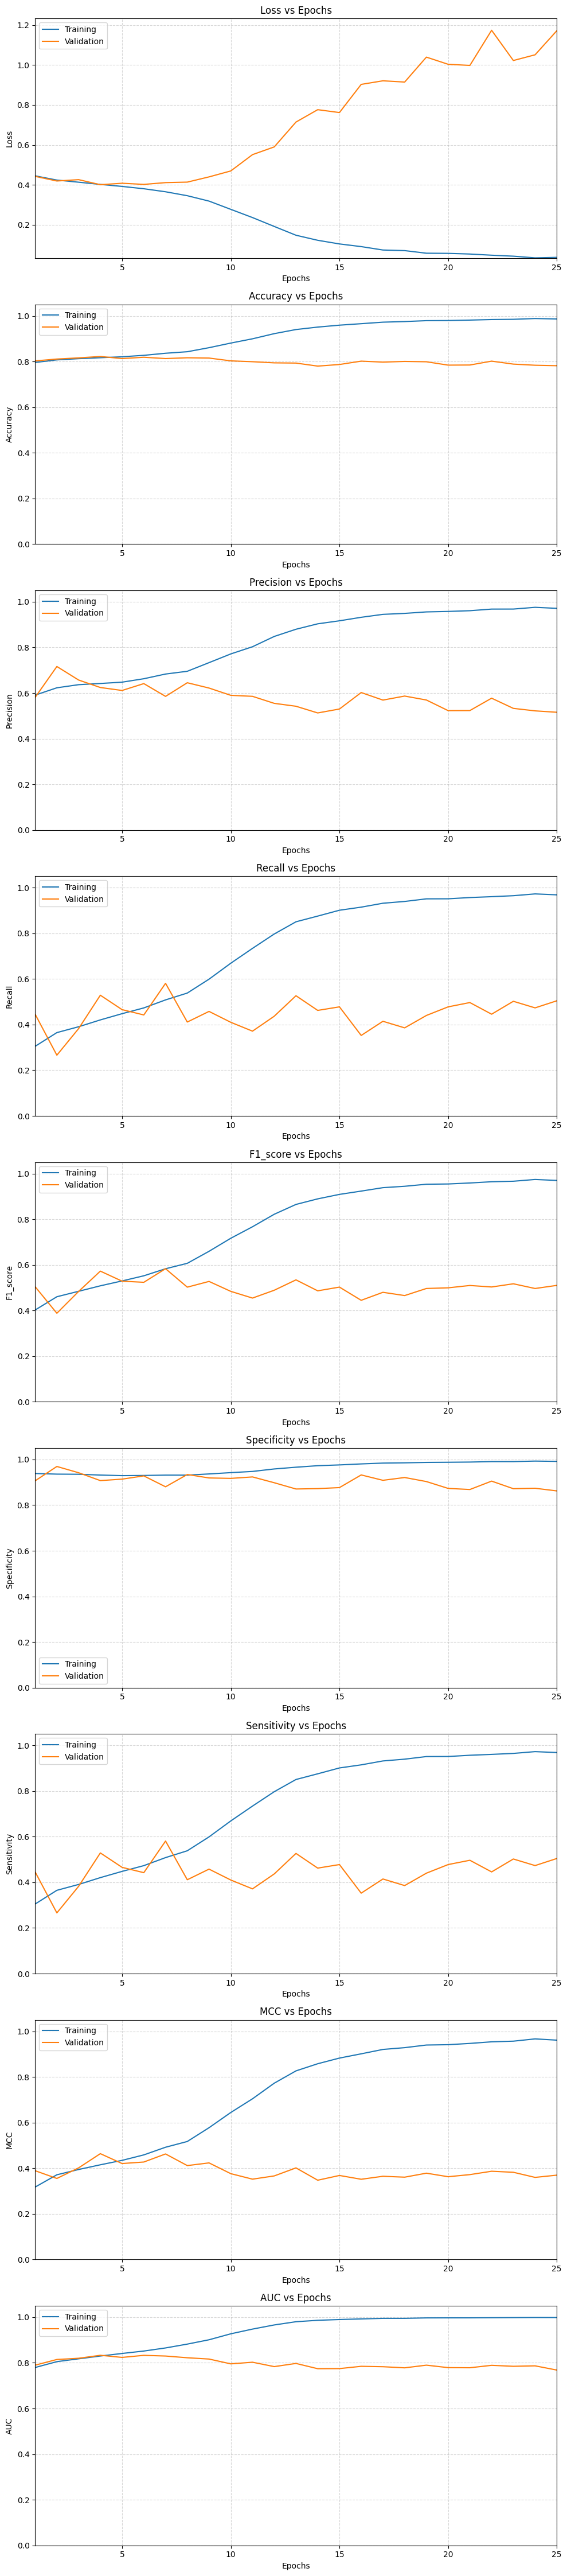

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots training and validation metrics over epochs (binary-safe).

    Args:
        train_metrics_history (dict)
        val_metrics_history (dict)
        metric_names (list)

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    fig, axes = plt.subplots(num_metrics, figsize=(10, 5 * num_metrics))

    if num_metrics == 1:
        axes = [axes]

    epochs = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = np.array(train_metrics_history[metric_name], dtype=np.float32)
        val_metric   = np.array(val_metrics_history[metric_name], dtype=np.float32)

        # 🔥 Handle NaNs (AUC edge cases)
        train_metric = np.nan_to_num(train_metric, nan=0.0)
        val_metric   = np.nan_to_num(val_metric, nan=0.0)

        ax.plot(epochs, train_metric, label="Training")
        ax.plot(epochs, val_metric, label="Validation")
        ax.legend()

        ax.set_xlabel("Epochs")
        ax.set_xlim(1, num_epochs)

        # ---------- LABELS ----------
        title = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_title(f"{title} vs Epochs")
        ax.set_ylabel(title)

        # ---------- Y AXIS SCALING ----------
        if metric_name == "loss":
            ymin = min(train_metric.min(), val_metric.min())
            ymax = max(train_metric.max(), val_metric.max())
            ax.set_ylim(ymin * 0.95, ymax * 1.05)
        else:
            ax.set_ylim(0.0, 1.05)

        ax.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


# Call
plot_metrics(train_metrics_history, val_metrics_history, metric_names)


In [ ]:
model.eval()

total_loss = 0.0
all_logits = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data = data.to(device)
        targets = targets.to(device).float()   # 🔥 MUST BE FLOAT

        logits = model(data).squeeze(1)        # 🔥 (B,)
        loss = criterion(logits, targets)

        total_loss += loss.item()

        all_logits.append(logits.detach().cpu())
        all_targets.append(targets.detach().cpu())

# ---------- AGGREGATE ----------
all_logits = torch.cat(all_logits)
all_targets = torch.cat(all_targets)

average_loss = total_loss / len(test_loader)

# ---------- METRICS ----------
test_metrics = custom_metrics(
    all_logits,
    all_targets,
    average_loss
)

# ---------- PRINT ----------
testing_metrics_line = "Test Metrics - "
testing_metrics_line += ", ".join(
    f"{k}: {v:.4f}" if k != "auc" else f"{k}: {v:.4f}"
    for k, v in test_metrics.items()
)

print(testing_metrics_line)


Testing Model: 100%|██████████| 251/251 [00:54<00:00,  4.65it/s]

Test Metrics - loss: 1.1050, accuracy: 0.7784, precision: 0.5084, recall: 0.5033, f1_score: 0.5058, specificity: 0.8584, sensitivity: 0.5033, mcc: 0.3631, auc: 0.7856


In [ ]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score
)

# ---------- TRUE LABELS ----------
true_labels = all_targets.cpu().numpy().astype(int)

# ---------- PREDICTIONS ----------
probs = torch.sigmoid(all_logits).cpu().numpy()
predicted_labels = (probs > 0.5).astype(int)

# ---------- CLASSIFICATION REPORT ----------
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=["Negative", "Positive"],  # 🔥 rename if needed
    digits=4,
    zero_division=0
)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy * 100:6.2f}%"
)


              precision    recall  f1-score   support

    Negative     0.8559    0.8584    0.8572      3101
    Positive     0.5084    0.5033    0.5058       902

    accuracy                         0.7784      4003
   macro avg     0.6822    0.6809    0.6815      4003
weighted avg     0.7776    0.7784    0.7780      4003

There were 887 errors in 4003 tests for an accuracy of  77.84%


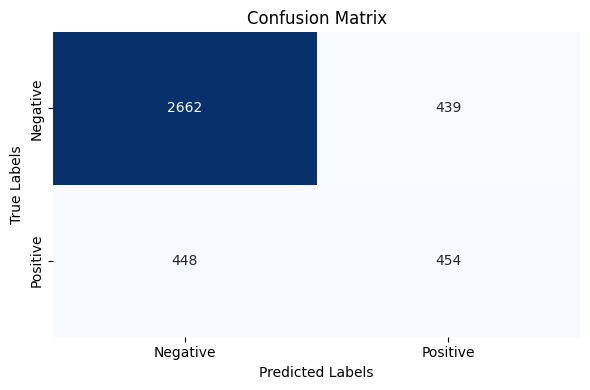

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------- COMPUTE CONFUSION MATRIX ----------
cm = confusion_matrix(true_labels, predicted_labels)

# ---------- PLOT ----------
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
